In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
PW = 8
PH = 6
plt.rcParams['figure.figsize'] = (PW, PH) 
plt.rcParams['image.cmap'] = 'gray'

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.max_rows = 250
pd.options.display.max_columns = 250

from scipy.stats import norm, skew
from scipy import stats
import math 
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("."))

# Any results you write to the current directory are saved as output.

['subm_2.csv', 'keras.csv', 'nnc.csv', 'test.csv', 'notebook.ipynb', 'subm_st.csv', '.ipynb_checkpoints', 'train.csv']


In [62]:
train = pd.read_csv("train.csv")
print ("Test shape: " + str(train.shape))
test = pd.read_csv("test.csv")
print ("Test shape: " + str(test.shape))

Test shape: (1460, 81)
Test shape: (1459, 80)


## Filter Outliers and Duplicates

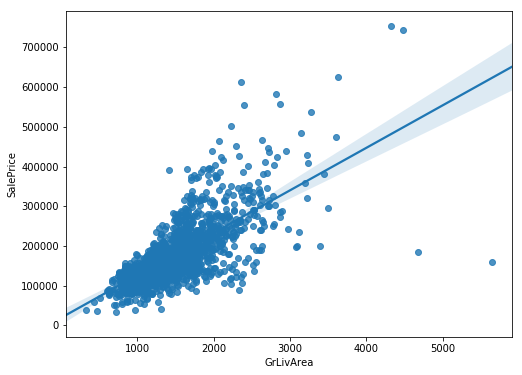

In [63]:
sns.regplot(data=train, x="GrLivArea", y="SalePrice");

In [64]:
oldL = len(train)
train = train[train.GrLivArea < 4000]
print("Number of outliers filtered: " + str(oldL - len(train)))

Number of outliers filtered: 4


In [65]:
print("Number of duplicated IDs: " + str(train.shape[0] - train.Id.nunique()))

Number of duplicated IDs: 0


## Explore

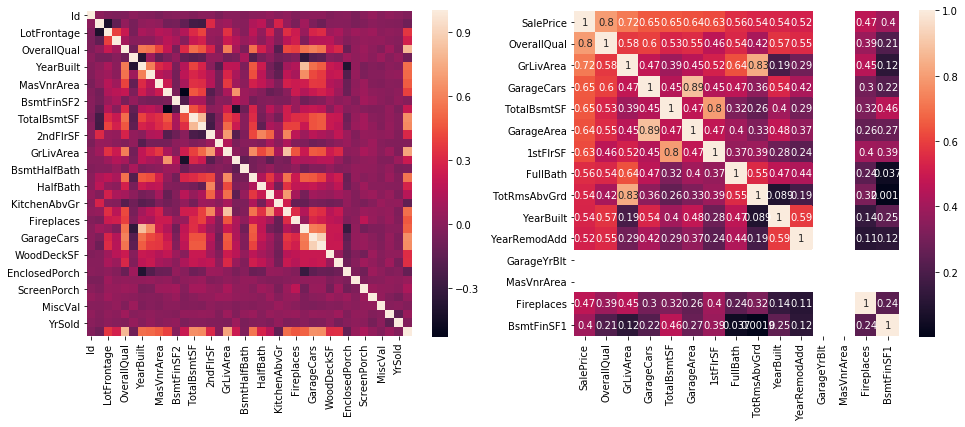

In [66]:
top = 15

#Correlation matrix
corr = train.corr()
f, ax = plt.subplots(1,2,figsize=(2*PW,PH))
sns.heatmap(corr, square=True, ax=ax[0]);

#10 largest corrs with SalePrice
tocorr = "SalePrice"#"LotFrontage"#
cols = corr.nlargest(top,tocorr)[tocorr].index
poly_cols = cols[1:]
corr2 = np.corrcoef(train[cols].T.values)
sns.heatmap(corr2, square=True, annot=True, yticklabels=cols.values, xticklabels=cols.values, ax=ax[1]);
#print(cols.values)

In [67]:
#Pair Plot
columns =['SalePrice','OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','YearRemodAdd']
#sns.pairplot(train[columns], size = 2)
#plt.show()

> ## SalePrice

Skew And Kurtosis: 1.5659592925562151 3.8852828233316745


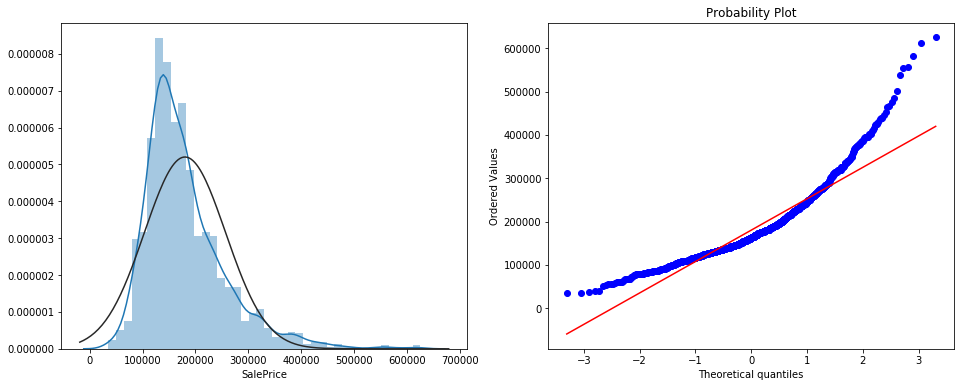

In [68]:
f, ax = plt.subplots(1,2,figsize=(2*PW,PH))
sns.distplot(train["SalePrice"], fit=norm, ax=ax[0]);
stats.probplot(train['SalePrice'], plot=ax[1])
print("Skew And Kurtosis:", train.SalePrice.skew(), train.SalePrice.kurt())

In [69]:
#Log Transform price
train.SalePrice = np.log1p(train.SalePrice)

Skew And Kurtosis: 0.06546006911025824 0.6664227710334405


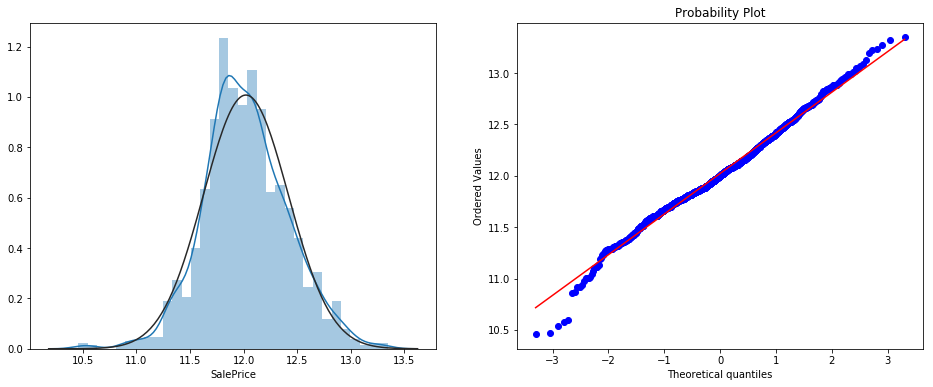

In [70]:
f, ax = plt.subplots(1,2,figsize=(2*PW,PH))
sns.distplot(train["SalePrice"], fit=norm, ax=ax[0]);
stats.probplot(train['SalePrice'], plot=ax[1])
print("Skew And Kurtosis:", train.SalePrice.skew(), train.SalePrice.kurt())

## Concat train/test

In [71]:
ntrain = train.shape[0]
ntest = test.shape[0]
testID = test.Id

df = pd.concat([train.loc[:, train.columns != "SalePrice"], test])
df.drop("Id", axis = 1, inplace = True)
y = train[["SalePrice"]]
print ("Concat shape:",df.shape, y.shape)

Concat shape: (2915, 79) (1456, 1)


## Fill NaNs

In [72]:
#IsNan Cols
p = (df.isnull().sum()/df.shape[0]).sort_values(ascending=False)
p = p[p > 0]
p

PoolQC          0.997256
MiscFeature     0.963979
Alley           0.932075
Fence           0.804460
FireplaceQu     0.487136
LotFrontage     0.166724
GarageCond      0.054545
GarageQual      0.054545
GarageYrBlt     0.054545
GarageFinish    0.054545
GarageType      0.053859
BsmtCond        0.028130
BsmtExposure    0.028130
BsmtQual        0.027787
BsmtFinType2    0.027444
BsmtFinType1    0.027101
MasVnrType      0.008233
MasVnrArea      0.007890
MSZoning        0.001372
BsmtHalfBath    0.000686
Utilities       0.000686
Functional      0.000686
BsmtFullBath    0.000686
BsmtFinSF2      0.000343
BsmtFinSF1      0.000343
Exterior2nd     0.000343
BsmtUnfSF       0.000343
TotalBsmtSF     0.000343
Exterior1st     0.000343
SaleType        0.000343
Electrical      0.000343
KitchenQual     0.000343
GarageArea      0.000343
GarageCars      0.000343
dtype: float64

## Plot NaNs

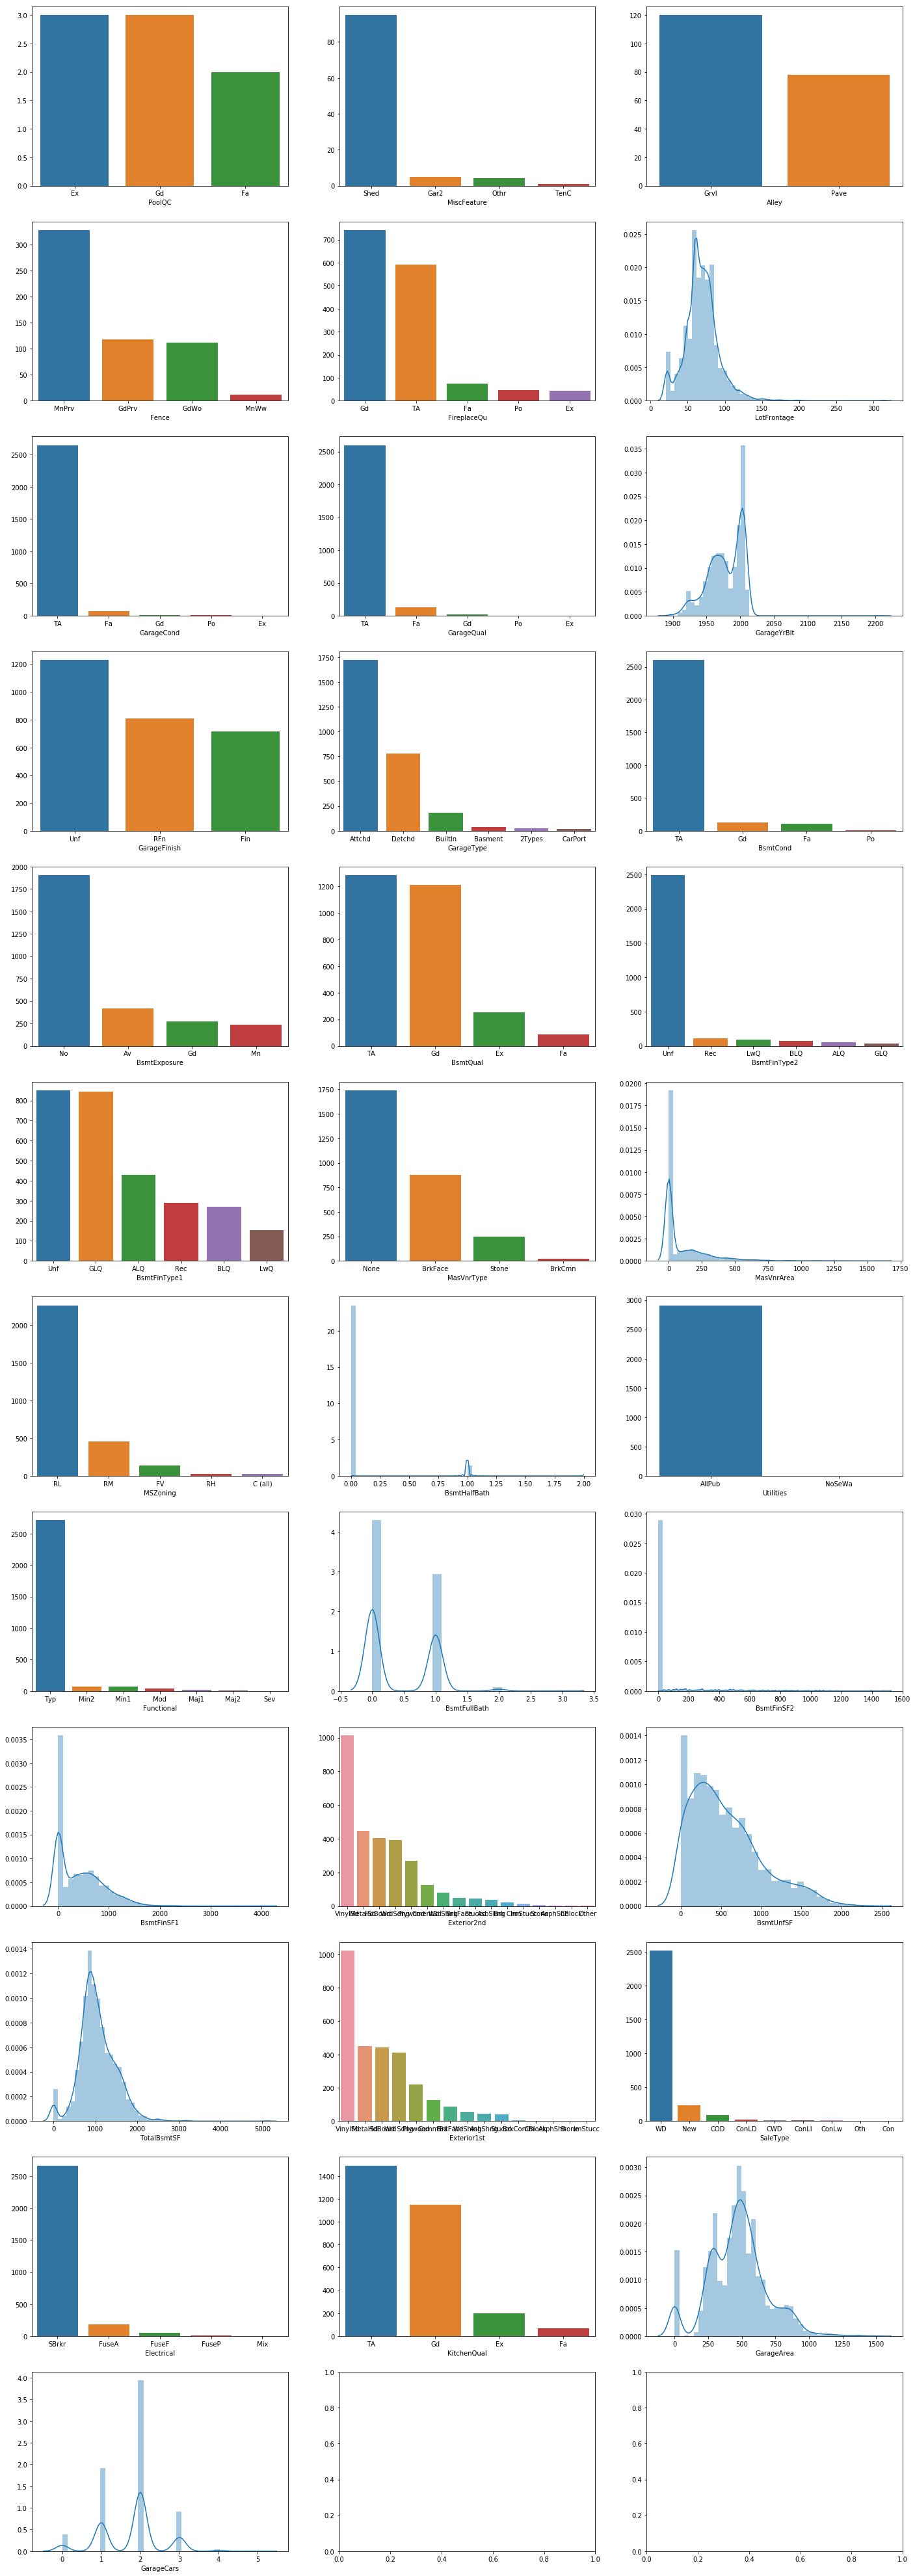

In [73]:
nrows = 3
ncols = int(np.ceil(len(p) / 3))
f, ax = plt.subplots(ncols, nrows, figsize=(nrows*PW,ncols*PH))
ind = 0
for col in p.index:
    if df[col].dtype == object:
        topl =  df[df[col].notnull()][col].value_counts()
        sns.barplot(x=np.array(topl.index), y= np.array(topl.values), ax=ax[int(ind/nrows),ind%nrows])
        ax[int(ind/nrows),ind%nrows].set_xlabel(col)
        ind += 1
    else:
        topl = df[df[col].notnull()][col]
        sns.distplot(topl, ax=ax[int(ind/nrows),ind%nrows])
        ind += 1

In [74]:
# #IsNan Rows
# p = (df.T.isnull().sum()).sort_values(ascending=False)
# p = p[p > 0]
# p 

In [75]:
#Fill Nones
noneCols = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageCond", "GarageQual", "GarageFinish", "GarageType", "BsmtCond",
            "BsmtExposure", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in noneCols:
    df[col] = df[col].fillna("None")

In [76]:
#Fill Zeros
zeroCols = ["LotFrontage", "MasVnrArea", "BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "KitchenQual",
            "GarageArea", "GarageCars"]
for col in zeroCols:
    df[col] = df[col].fillna(0)

In [77]:
#Fill Median/Mode
medCols = ["GarageYrBlt", "MSZoning", "Utilities", "Functional", "Exterior1st", "Exterior2nd", "SaleType", "Electrical"]
for col in medCols:
    if df[col].dtype != object:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

In [78]:
#IsNan Cols
p = (df.isnull().sum()/df.shape[0]).sort_values(ascending=False)
p = p[p > 0]
p

Series([], dtype: float64)

## Feature Engeneering

In [79]:
#Numerical to Categorical
df["MSSubClass"] = df["MSSubClass"].map(lambda x: "MSSC" + str(x))

df["MoSold"] = df["MoSold"].map(lambda x: "MS_" + str(x))
df['YrSold'] = df['YrSold'].map(lambda x: "YS_" + str(x))

In [80]:
#ExPo to Ordinal
mapExPo = {"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5}
columns = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageCond", "GarageQual"]
for col in columns:
   df = df.replace({col:mapExPo})

In [81]:
#Other Ordinals
df = df.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                "BsmtExposure" : {"No":0, "None":0, "Mn":1, "Av":2, "Gd":3},
                "BsmtFinType1" : {"No":0, "None":0, "Unf":1, "LwQ":2, "Rec": 3, "BLQ":4, "ALQ":5, "GLQ":6},
                "BsmtFinType2" : {"No":0, "None":0, "Unf":1, "LwQ":2, "Rec": 3, "BLQ":4, "ALQ":5, "GLQ":6},
                "Functional" : {"Sal":1, "Sev":2, "Maj2":3, "Maj1":4, "Mod":5, "Min2":6, "Min1":7, "Typ":8}, 
                "LandSlope" : {"Sev":1, "Mod":2, "Gtl":3},
                "LotShape" : {"IR3":1, "IR2":2, "IR1":3, "Reg":4},
                "PavedDrive" : {"N":0, "P":1, "Y":2},
                "Street" : {"Grvl":1, "Pave":2},
                "Utilities" : {"ELO":1, "NoSeWa":2, "NoSewr":3, "AllPub":4}})

In [82]:
#Adding features
df['SumSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

In [83]:
#Dividing cat and num
cat_features = df.select_dtypes(include = ["object"]).columns
num_features = df.select_dtypes(exclude = ["object"]).columns
print("Number of categorical:", cat_features.shape[0])
print("Number of numerical:", num_features.shape[0])

Number of categorical: 28
Number of numerical: 52


In [84]:
skews = df[num_features].apply(lambda x: x.skew()).sort_values(ascending=False)
skew_lim = 0.5
columns = skews[abs(skews) > 0.5].index
print(skews)
df[columns] = df[columns].applymap(lambda x: np.log1p(x))

MiscVal          21.943440
PoolArea         18.711459
LotArea          13.130516
LowQualFinSF     12.086535
3SsnPorch        11.373947
KitchenAbvGr      4.301059
BsmtFinSF2        4.144996
EnclosedPorch     4.002856
ScreenPorch       3.945539
BsmtHalfBath      3.944922
BsmtFinType2      3.151185
MasVnrArea        2.602036
OpenPorchSF       2.530548
WoodDeckSF        1.849236
ExterCond         1.314902
1stFlrSF          1.253657
BsmtExposure      1.243508
GrLivArea         0.978364
BsmtFinSF1        0.974640
SumSF             0.936655
BsmtUnfSF         0.920609
2ndFlrSF          0.843671
ExterQual         0.783349
TotRmsAbvGrd      0.749965
Fireplaces        0.726331
HalfBath          0.699130
TotalBsmtSF       0.662998
BsmtFullBath      0.623140
OverallCond       0.569436
KitchenQual       0.384472
BedroomAbvGr      0.328298
GarageArea        0.217860
OverallQual       0.181995
FireplaceQu       0.174465
FullBath          0.160000
LotFrontage      -0.134742
BsmtFinType1     -0.147306
G

In [85]:
# skews = df[num_features].apply(lambda x: x.skew()).sort_values(ascending=False)
# print(skews)

## Dummy Variables

In [86]:
print("Before converting:", df.shape)
df = pd.get_dummies(df)
print("Afetr converting:", df.shape)

Before converting: (2915, 80)
Afetr converting: (2915, 264)


## Model

In [40]:
#Skip fo NN Model
#Add Poly top 10
maxd = 2

print(df.shape)

temp = set(poly_cols) & set(num_features)
for deg in range(2, maxd+1):
    for c in temp:
        df[c + str(deg)] = df[c] ** deg

print(df.shape)

(2915, 264)
(2915, 278)


In [87]:
train = df[:ntrain]
test = df[ntrain:]

In [88]:
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso, BayesianRidge
from sklearn.preprocessing import RobustScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#from xgboost.sklearn import XGBRegressor

In [89]:
#Scale train/test
scaler = RobustScaler().fit(train.loc[:,num_features])

train.loc[:,num_features] = scaler.transform(train.loc[:,num_features])
test.loc[:,num_features] = scaler.transform(test.loc[:,num_features]) 

/home/brunno/anaconda2/envs/ana41py35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [90]:
#Split  Train/Test
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=29) #
print(X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0])

1164 292 1164 292


In [45]:
# # #Scaling
# scaler = RobustScaler().fit(X_train.loc[:,num_features])

# X_train.loc[:,num_features] = scaler.transform(X_train.loc[:,num_features])
# X_test.loc[:,num_features] = scaler.transform(X_test.loc[:,num_features])

In [46]:
# def rmse(clf, X, y, splits=5, print_out=False, plot=False):
#     kf = KFold(splits, shuffle=False, random_state=29)
#     train_errors = []
#     test_errors = []
#     for train_index, test_index in kf.split(X):
#         X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]        
#         y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]
        
#         clf = clf.fit(X_train, y_train)
        
#         y_pred_train = clf.predict(X_train)
#         y_pred_test = clf.predict(X_test)
        
#         if plot:
#             plt.figure()
#             sns.regplot(x=y_test.squeeze(), y=y_pred_test.squeeze())
#             sns.regplot(x=y_train.squeeze(), y=y_pred_train.squeeze())
        
#         train_errors.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
#         test_errors.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
        
#     if print_out:
#         print ("Train error:", np.mean(train_errors), np.std(train_errors))
#         print ("Test error:" , np.mean(test_errors), np.std(test_errors))
#     return (np.mean(train_errors), np.mean(test_errors))

In [47]:
def calc_rmse(y_test, y_pred_test):
    return np.sqrt(mean_squared_error(y_test, y_pred_test))

In [48]:
def rmse_cvs(clf, X, y, splits=5):
    cvs = cross_val_score(clf, X, y, scoring="neg_mean_squared_error", cv=splits, n_jobs=-1 )
    cvs_rmse = np.sqrt(-cvs)
    return  cvs_rmse.mean(), cvs_rmse.var()

In [49]:
def evaluate_clas(clf, X_test, y_test):
    y_pred_test = clf.predict(X_test)
    clf_name = repr(clf).split("(")[0]
    print(clf_name, np.mean(calc_rmse(y_test, y_pred_test)))
    return 

In [50]:
#LASSO
clf = Lasso( max_iter = 20000)
feed_dict = {
             #"alpha": np.logspace(-1, -5, num=5) # 0.001
             "alpha" : np.arange(0.0002, 0.0010, 0.0001) #0.0005 
            }
gs = GridSearchCV(clf, param_grid=feed_dict,  scoring="neg_mean_squared_error", cv=5 )
gs.fit(X_train, y_train)
gs.best_params_

{'alpha': 0.0006000000000000001}

In [51]:
#Ridge
clf = Ridge()
feed_dict = {
              #"alpha": np.logspace(2, -2, num=5) # 10
             "alpha" : np.arange(10, 20, 1) # 19
            }
gs = GridSearchCV(clf, param_grid=feed_dict,  scoring="neg_mean_squared_error", cv=5 )
gs.fit(X_train, y_train)
gs.best_params_

{'alpha': 19}

In [52]:
#ElsticNet
clf = ElasticNet(max_iter = 20000)
feed_dict = {
              #"alpha": np.logspace(-1, -5, num=5) # 0.001
              "alpha" : np.arange(0.0002, 0.002, 0.0002) # 0.001
            }
gs = GridSearchCV(clf, param_grid=feed_dict,  scoring="neg_mean_squared_error", cv=5 )
gs.fit(X_train, y_train)
gs.best_params_

{'alpha': 0.0012000000000000001}

In [53]:
#GradientBoostingRegressor
clf = GradientBoostingRegressor( )#min_samples_leaf=19, min_samples_split=5)  #min_samples_leaf and min_samples_split
feed_dict = {
              #"min_samples_leaf" : np.arange(15, 25, 1) # 19
              #"min_samples_split": np.arange(2,10,1) #5
              #"n_estimators" : np.arange(400, 1600, 200)
            }
gs = GridSearchCV(clf, param_grid=feed_dict,  scoring="neg_mean_squared_error", cv=5 )
gs.fit(X_train, y_train.squeeze())
gs.best_params_

{}

In [54]:
clfs = [
        Lasso(alpha=0.0005, max_iter = 20000),
        Ridge(alpha=19),
        ElasticNet(alpha=0.001,  max_iter = 20000),
        #GradientBoostingRegressor(n_estimators=1000) 

        ]

In [55]:
for clf in clfs:
    cvs = rmse_cvs(clf, X_train, y_train)
    clf_name = repr(clf).split("(")[0]
    print(clf_name, cvs)

Lasso (0.1092593973414276, 0.00010160977246021147)
Ridge (0.11087287387135583, 8.963543000624447e-05)
ElasticNet (0.10917179306583158, 0.00010186192827309551)


In [56]:
for clf in clfs:
    clf = clf.fit(X_train, y_train)
    evaluate_clas(clf, X_test, y_test)

Lasso 0.11994297513339852
Ridge 0.12072748913274721
ElasticNet 0.120387937082353


##  Stacking Average

In [57]:
def stacking(clfs, X, y, splits=10):
    kf = KFold(splits, shuffle=True, random_state=29)
    
    fitted_cfls = []
    preds = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]        
        y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]
        
        for clf in clfs:
            
            clf = clf.fit(X_train, y_train)
            fitted_cfls.append(clf)
        
            y_pred = clf.predict(X)
            preds = np.append(preds, y_pred)

            
    return fitted_cfls, pd.DataFrame(preds.reshape(-1,X.shape[0]).T)

In [58]:
def stack_clfs(clfs, X_test):
    preds = []
    for clf in clfs: 
        y_pred = clf.predict(X_test)
        preds = np.append(preds,y_pred)
    return pd.DataFrame(preds.reshape(-1,X_test.shape[0]).T)

In [59]:
fclfs, preds = stacking(clfs, X_train, y_train)
p = stack_clfs(fclfs, X_test)

y_pred_test = p.mean(axis=1) 
print(np.mean(np.sqrt(mean_squared_error(y_test, y_pred_test))))

0.11987283080336229


In [60]:
def predict_csv_stack(clfs, test):
    y_pred = stack_clfs(fclfs, test).mean(axis=1)
    ndf = pd.DataFrame({"Id":testID, "SalePrice": np.exp(y_pred)})
    return ndf

res = predict_csv_stack(fclfs, test)
res.to_csv("subm_st.csv", index=False)

## Keras

In [91]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers

/home/brunno/anaconda2/envs/ana41py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
def create_model():
    model = Sequential()
    initializer = "normal"
    optimizer = Adam(lr=0.004)#"adam"
    #drop = 0.005
    reg1 = regularizers.l1(0.008)
    reg2 = regularizers.l2(0.002)
    #model.add(Dropout(drop, input_shape=(train.shape[1],)))
    model.add(Dense(32, input_dim=train.shape[1], kernel_initializer=initializer, activation='relu', kernel_regularizer=reg1)) 
    #model.add(Dropout(drop))
    model.add(Dense(16, kernel_initializer=initializer, activation='relu', kernel_regularizer=reg2))
    #model.add(Dense(8, kernel_initializer=initializer, activation='relu'))
    #model.add(Dropout(drop))
    model.add(Dense(1, kernel_initializer=initializer, activation='linear', kernel_regularizer=reg2))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

clf = KerasRegressor(build_fn=create_model, epochs=32000, batch_size=X_train.shape[0], verbose=False) # batch_size=X_train.shape[0]

hist = clf.fit(X_train, y_train, validation_data=(X_test, y_test))
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print (np.sqrt(mean_squared_error(y_train, y_pred_train)))
print (np.sqrt(mean_squared_error(y_test, y_pred_test)))


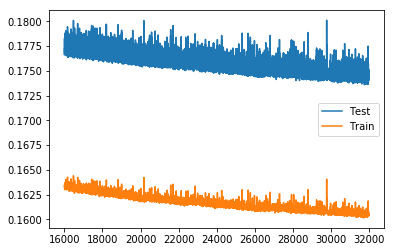

In [335]:
pd.DataFrame(({"Train":np.sqrt(hist.history['loss']), "Test":np.sqrt(hist.history['val_loss'])}))[16000:].plot();

In [ ]:
pd.DataFrame(({"Train":np.sqrt(hist.history['loss']), "Test":np.sqrt(hist.history['val_loss'])}))[16000:].plot();

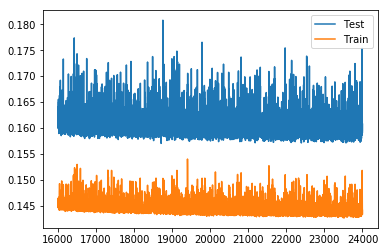

In [307]:
pd.DataFrame(({"Train":np.sqrt(hist.history['loss']), "Test":np.sqrt(hist.history['val_loss'])}))[16000:24000].plot();

## Submission

In [308]:
def predict_csv(train, y, clf, test):
    clf.fit(train, y) #clf = 
    y_pred = clf.predict(test)
    print(len(y_pred),len(testID))
    ndf = pd.DataFrame({"Id":testID, "SalePrice": np.exp(y_pred)})
    return ndf

In [309]:
clf = KerasRegressor(build_fn=create_model, epochs=16000, batch_size=256, verbose=False)

res = predict_csv(train, y, clf, test)
res.to_csv("nnc.csv", index=False)

1459 1459
